In [11]:
# ----------------------------------------
# Imports
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split

In [2]:
# Contoh model (Advanced + Ensemble, tanpa naive bayes & logistic)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
data=pd.read_excel("D:\DATAS\ALDEN\DATA ALDEN.xlsx")
df=data.drop(columns='Kab')
df.head(2)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,1,1,60,1,2,1,7,7,1,5,5,1,5,5,2,83,13,0
1,1,1,54,1,2,1,7,7,1,5,5,5,5,5,4,80,3,0


In [4]:
x=df.drop(columns='Y')
y=df['Y']

In [7]:
x_insample, x_outsample, y_insample, y_outsample = train_test_split(x,y, test_size=0.1, random_state=42,shuffle=True)

In [8]:
# ----------------------------------------
# 1. Set Model & Hyperparameter Distributions
# ----------------------------------------
all_models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGB": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [9]:
param_distributions = {
    "DT": {
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy", "log_loss"]
    },
    "RF": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1]
    },
    "XGB": {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.7, 0.8, 1]
    },
    "CatBoost": {
        "iterations": [200, 500],
        "depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1]
    },
    "LightGBM": {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 7, -1],
        "learning_rate": [0.01, 0.05, 0.1]
    }
}


In [13]:
# ----------------------------------------
# 2. Cross-validation setup
# ----------------------------------------
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ----------------------------------------
# 3. Train & Tune
# ----------------------------------------
best_models = {}
results = {}

In [14]:
for name, model in all_models.items():
    print(f"\nTuning {name}...")

    if name in param_distributions and param_distributions[name]:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions[name],
            n_iter=20,
            cv=cv,
            scoring='roc_auc',
            random_state=42,
            n_jobs=-1
        )
        search.fit(x_insample, y_insample)
        best_estimator = search.best_estimator_
        best_params = search.best_params_
    else:
        best_estimator = model
        best_estimator.fit(x_insample, y_insample)
        best_params = None

    best_models[name] = best_estimator

    # Prediksi in-sample
    y_pred_insample = best_estimator.predict(x_insample)
    try:
        y_proba_insample = best_estimator.predict_proba(x_insample)[:,1]
    except:
        y_proba_insample = None

    # Prediksi out-sample
    y_pred_outsample = best_estimator.predict(x_outsample)
    try:
        y_proba_outsample = best_estimator.predict_proba(x_outsample)[:,1]
    except:
        y_proba_outsample = None

    # Hitung metrics
    results[name] = {
        "Best Params": best_params,
        "Train ROC-AUC": roc_auc_score(y_insample, y_proba_insample) if y_proba_insample is not None else None,
        "Outsample ROC-AUC": roc_auc_score(y_outsample, y_proba_outsample) if y_proba_outsample is not None else None,
        "Train Accuracy": accuracy_score(y_insample, y_pred_insample),
        "Outsample Accuracy": accuracy_score(y_outsample, y_pred_outsample),
        "Train F1": f1_score(y_insample, y_pred_insample),
        "Outsample F1": f1_score(y_outsample, y_pred_outsample),
        "Train LogLoss": log_loss(y_insample, y_proba_insample) if y_proba_insample is not None else None,
        "Outsample LogLoss": log_loss(y_outsample, y_proba_outsample) if y_proba_outsample is not None else None
    }


Tuning DT...

Tuning RF...

Tuning AdaBoost...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Tuning XGB...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Tuning CatBoost...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Tuning LightGBM...
[LightGBM] [Info] Number of positive: 4588, number of negative: 786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 5374, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,853740 -> initscore=1,764243
[LightGBM] [Info] Start training from score 1,764243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [15]:
# Convert ke DataFrame
results_df = pd.DataFrame(results).T

In [16]:
results_df

,Best Params,Train ROC-AUC,Outsample ROC-AUC,Train Accuracy,Outsample Accuracy,Train F1,Outsample F1,Train LogLoss,Outsample LogLoss
DT,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.863743,0.867844,0.865836,0.864548,0.926074,0.924228,0.292294,0.404662
RF,"{'n_estimators': 200, 'min_samples_split': 10,...",0.946664,0.890514,0.895981,0.869565,0.942103,0.926276,0.234047,0.286282
AdaBoost,"{'n_estimators': 200, 'learning_rate': 0.1}",0.872178,0.900319,0.87086,0.869565,0.927753,0.925,0.624184,0.622535
XGB,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",0.894622,0.900456,0.882397,0.867893,0.933836,0.923671,0.267859,0.272926
CatBoost,"{'learning_rate': 0.01, 'iterations': 500, 'de...",0.914246,0.901849,0.891515,0.869565,0.939429,0.925714,0.252629,0.273121
LightGBM,"{'n_estimators': 200, 'max_depth': 3, 'learnin...",0.897579,0.897438,0.883141,0.867893,0.934419,0.923965,0.265115,0.275931


In [17]:
# ----------------------------------------
# 4. Visualisasi Train vs Outsample
# ----------------------------------------
plot_df = results_df.reset_index().melt(
    id_vars="index",
    value_vars=[
        "Train ROC-AUC", "Outsample ROC-AUC",
        "Train Accuracy", "Outsample Accuracy",
        "Train F1", "Outsample F1"
    ],
    var_name="Dataset_Metric",
    value_name="Score"
)


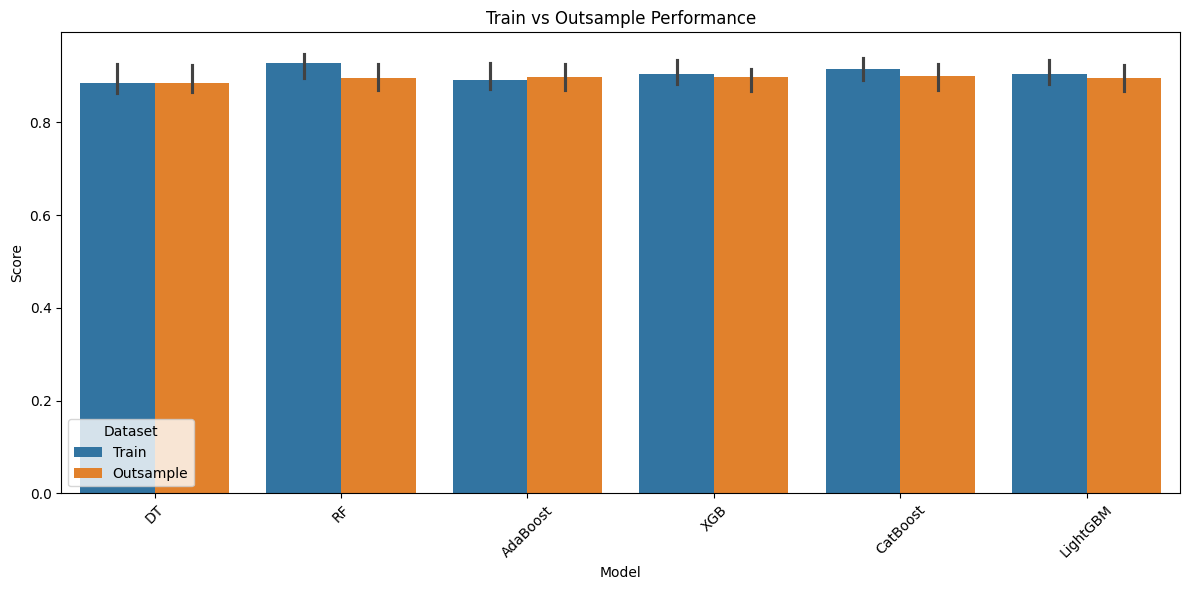

In [18]:
plot_df[["Dataset", "Metric"]] = plot_df["Dataset_Metric"].str.split(" ", expand=True)

plt.figure(figsize=(12,6))
sns.barplot(data=plot_df, x="index", y="Score", hue="Dataset")
plt.xticks(rotation=45)
plt.title("Train vs Outsample Performance")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

In [19]:
# Fungsi evaluasi model
def evaluate_model_stats(model, x_train, y_train, x_test, y_test, n_rademacher=100):
    """
    Menghitung 3 statistik:
    - Rademacher complexity (aproksimasi sederhana)
    - Hoeffding excess risk
    - Gap risk
    """
    # Prediksi
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # 1. Rademacher complexity (aproksimasi sederhana)
    n_samples = x_train.shape[0]
    rademacher_scores = []
    for _ in range(n_rademacher):
        sigma = np.random.choice([-1, 1], size=n_samples)
        score = np.mean(sigma * (y_train_pred == y_train))
        rademacher_scores.append(score)
    rademacher_complexity = np.mean(np.abs(rademacher_scores))

    # 2. Hoeffding excess risk
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    hoeffding_excess_risk = train_acc - test_acc

    # 3. Gap risk
    gap_risk = test_acc - train_acc

    return {
        "Rademacher Complexity": rademacher_complexity,
        "Hoeffding Excess Risk": hoeffding_excess_risk,
        "Gap Risk": gap_risk,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    }

# Evaluasi semua model di best_models
stats_df = pd.DataFrame({
    name: evaluate_model_stats(model, x_insample, y_insample, x_outsample, y_outsample)
    for name, model in best_models.items()
}).T

print(stats_df)


          Rademacher Complexity  Hoeffding Excess Risk  Gap Risk  \
DT                     0.009840               0.001287 -0.001287   
RF                     0.008333               0.026415 -0.026415   
AdaBoost               0.010060               0.001294 -0.001294   
XGB                    0.009606               0.014504 -0.014504   
CatBoost               0.009974               0.021949 -0.021949   
LightGBM               0.009163               0.015248 -0.015248   

          Train Accuracy  Test Accuracy  
DT              0.865836       0.864548  
RF              0.895981       0.869565  
AdaBoost        0.870860       0.869565  
XGB             0.882397       0.867893  
CatBoost        0.891515       0.869565  
LightGBM        0.883141       0.867893  


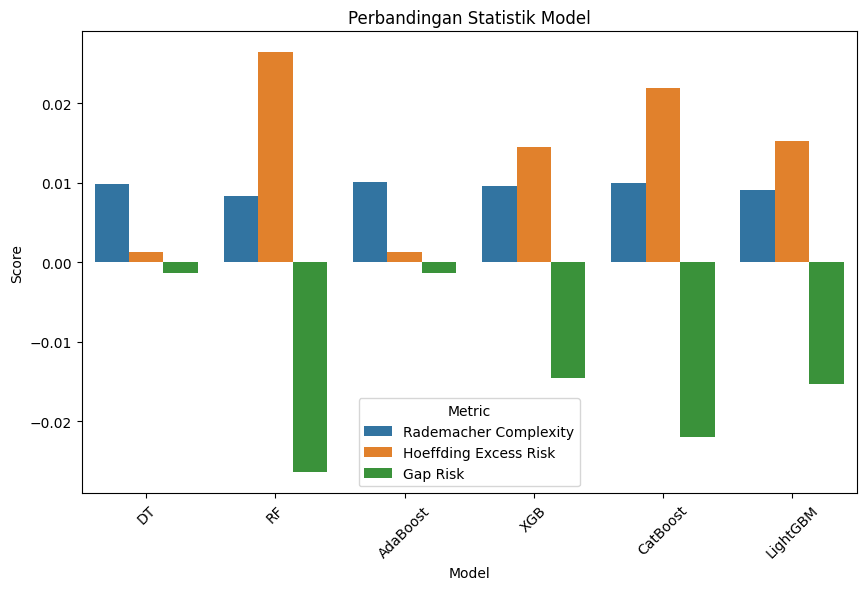

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah ke format long
plot_df = stats_df.reset_index().melt(
    id_vars="index",
    value_vars=["Rademacher Complexity", "Hoeffding Excess Risk", "Gap Risk"],
    var_name="Metric",
    value_name="Score"
)

plot_df.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric")
plt.title("Perbandingan Statistik Model")
plt.xticks(rotation=45)
plt.show()
